# Evaluation of the computed production plans

In [1]:
import time
import os
import sys
import pandas as pd
import matplotlib.pyplot as plt
sys.path.append(os.path.abspath('..'))
from constants.constants import PRODUCT_PROPERTIES, EVALUATIONS_FOLDER, PROJECT_FOLDER
sys.path.append(PROJECT_FOLDER)
from src.experiment.utils import calculate_oct
from src.experiment.approaches.logic_program import run_clingo
from src.experiment.approaches.tsp_solver import run_concorde

plt.rcParams['figure.dpi'] = 300

### Loading the actual production plans of the previous weeks

In [2]:
filename = os.path.join(EVALUATIONS_FOLDER, 'adapted_production_plans.xlsx')

actual_plans = pd.read_excel(filename, sheet_name=None, dtype=str)
weeks = list(actual_plans.keys())
actual_plans[weeks[0]]

,Linie,Produkt,Menge
0,3,23545,0
1,3,22276,60
2,3,22720,60
3,3,18919,75
4,3,15101,100
5,3,17151,50
6,3,15227,20
7,3,16214,50
8,3,15950,150
9,3,12020,160


### Fetching the plan activity to calculate the planned availability

In [3]:
filename = os.path.join(EVALUATIONS_FOLDER, 'product_plan_activity.csv')

df_plan_activity = pd.read_csv(filename, sep=';', dtype={'Product': str}).set_index('Product')
df_plan_activity

,Plan Activity
Product,
12020,19500
12021,19500
13327,19500
15097,13500
15099,13500
...,...
23542,12500
23545,1
23546,1


### Loading the product properties

In [4]:
df_properties = pd.read_csv(PRODUCT_PROPERTIES, dtype={'Product': str}).set_index('Product')
df_properties

,Name,Campaign,Volume,BottleCrate,NumShrink,NumTray,Packaging,PlannedPerformance
Product,,,,,,,,
12020,Rivella Rot Tr 24x50 PE,Rot,50,False,1,24,Normal,19500
12021,Rivella Blau Tr 24x50 PE,Blau,50,False,1,24,Normal,19500
13327,Rivella Grüntee Tr 24x50 PE,Gruentee,50,False,1,24,Normal,19500
15097,Rivella Blau Sc 6x150 PE,Blau,150,False,1,6,Normal,13500
15099,Rivella Grüntee Sc 6x150 PE,Gruentee,150,False,1,6,Normal,13500
...,...,...,...,...,...,...,...,...
23446,Rivella Blau Tr 3x8x50 PET Landi,Blau,50,False,3,8,Landi,18000
23545,Sterilisation zu Wochenbeginn,Sterilisation_zu_Wochenbeginn,0,-,0,0,-,1
23546,Zwischensterilisation,Zwischensterilisation,0,-,0,0,-,1


## Evaluate the computed product order regarding the actual plan

In [5]:
df_results = pd.DataFrame([],
    index=pd.Index([], name='KW'),
    columns=['IST-OCT', 'IST-GV', 'OPT-OCT', 'OPT-GV', 'time', 'numProducts', 'actual_order', 'computed_order'])

for week, df_actual_plan in actual_plans.items():
    if week in ['KW47']:
        continue

    print('week:', week)
    actual_order = df_actual_plan['Produkt'].to_list()
    assert len(actual_order) > 0

    occurences = {actual_order[0]: 1}
    for i in range(1, len(actual_order)):
        if actual_order[i] == actual_order[i - 1]:
            occurences[actual_order[i]] += 1
        else:
            assert actual_order[i] not in occurences
            occurences[actual_order[i]] = 1

    products = set(occurences.keys())

    # IST
    actual_order = list(occurences.keys())

    # OPT
    t = time.time()
    _, computed_order, _, _ = run_clingo(products, run=0, consider_constraints=3)
    # computed_order, _ = run_concorde(products, run=0, consider_constraints=3)
    # print(computed_order)
    t = time.time() - t
    assert len(products) == len(computed_order)

    # Overall changeover time
    ist_oct = calculate_oct(actual_order)
    opt_oct = calculate_oct(computed_order)

    overall_duration = 0
    for product in products:
        # print('product:', product)

        quantity = int(df_actual_plan[df_actual_plan['Produkt'] == product]['Menge'].iloc[0]) * 1000
        # print('quantity:', quantity)

        plan_activity = df_plan_activity.at[product, 'Plan Activity']
        # print('plan_activity:', plan_activity)

        duration_product = float(quantity) / plan_activity * 60
        # print('duration_product:', duration_product)

        overall_duration += duration_product

    # print('overall_duration:', overall_duration)
    ist_planned_stopps = ist_oct
    opt_planned_stopps = opt_oct
    ist_pa = (overall_duration - ist_planned_stopps) / overall_duration
    opt_pa = (overall_duration - opt_planned_stopps) / overall_duration

    result = [ist_oct, ist_pa, opt_oct, opt_pa, t, len(products), actual_order, computed_order]
    df_results.loc[week] = result

df_results

week: KW48
week: KW49
week: KW50
week: KW51
week: KW01
week: KW02
week: KW04
week: KW06
week: KW07
week: KW08
week: KW09
week: KW10
week: KW11
week: KW13
week: KW14
week: KW15
week: KW17


,IST-OCT,IST-GV,OPT-OCT,OPT-GV,time,numProducts,actual_order,computed_order
KW,,,,,,,,
KW48,2070,0.645781,2040,0.650914,0.419743,26,"[23545, 15952, 13327, 15229, 15099, 15101, 227...","[23545, 15099, 15229, 15952, 13327, 16214, 159..."
KW49,1365,0.704144,1350,0.707395,0.105598,16,"[23545, 22362, 19375, 22721, 15097, 18920, 189...","[23545, 22362, 19375, 22721, 18920, 15097, 231..."
KW50,1800,0.667558,1770,0.673098,0.161933,26,"[23545, 21849, 21968, 21845, 21847, 21846, 218...","[23545, 15227, 17151, 23444, 12020, 16214, 159..."
KW51,1320,0.691174,1305,0.694683,0.195330,20,"[23545, 15951, 12021, 19375, 22362, 15231, 227...","[23545, 19375, 22362, 15097, 18920, 22721, 222..."
KW01,1770,0.447623,1785,0.442941,0.170360,23,"[23545, 18920, 22721, 16215, 15951, 12021, 120...","[23545, 22721, 18920, 15951, 16215, 12021, 120..."
KW02,1140,0.719887,1125,0.723573,0.083547,15,"[23545, 15951, 12021, 19047, 23446, 18920, 150...","[23545, 18920, 15097, 15951, 12021, 23446, 190..."
KW04,1560,0.624994,1545,0.628600,0.145358,19,"[23545, 21865, 21846, 21847, 23071, 21849, 219...","[23545, 22362, 19375, 15097, 15951, 12021, 159..."
KW06,1185,0.775363,1170,0.778207,0.088122,15,"[23545, 12021, 15951, 22275, 15231, 22721, 227...","[23545, 22275, 22721, 15231, 15951, 12021, 159..."
KW07,1635,0.722659,1620,0.725204,0.102069,23,"[23545, 22202, 21865, 21846, 21849, 23614, 218...","[23545, 23614, 21850, 21849, 22202, 21846, 218..."


In [6]:
df_results.to_csv('evaluation_results.csv')

#### Plot savings in overall changeover time

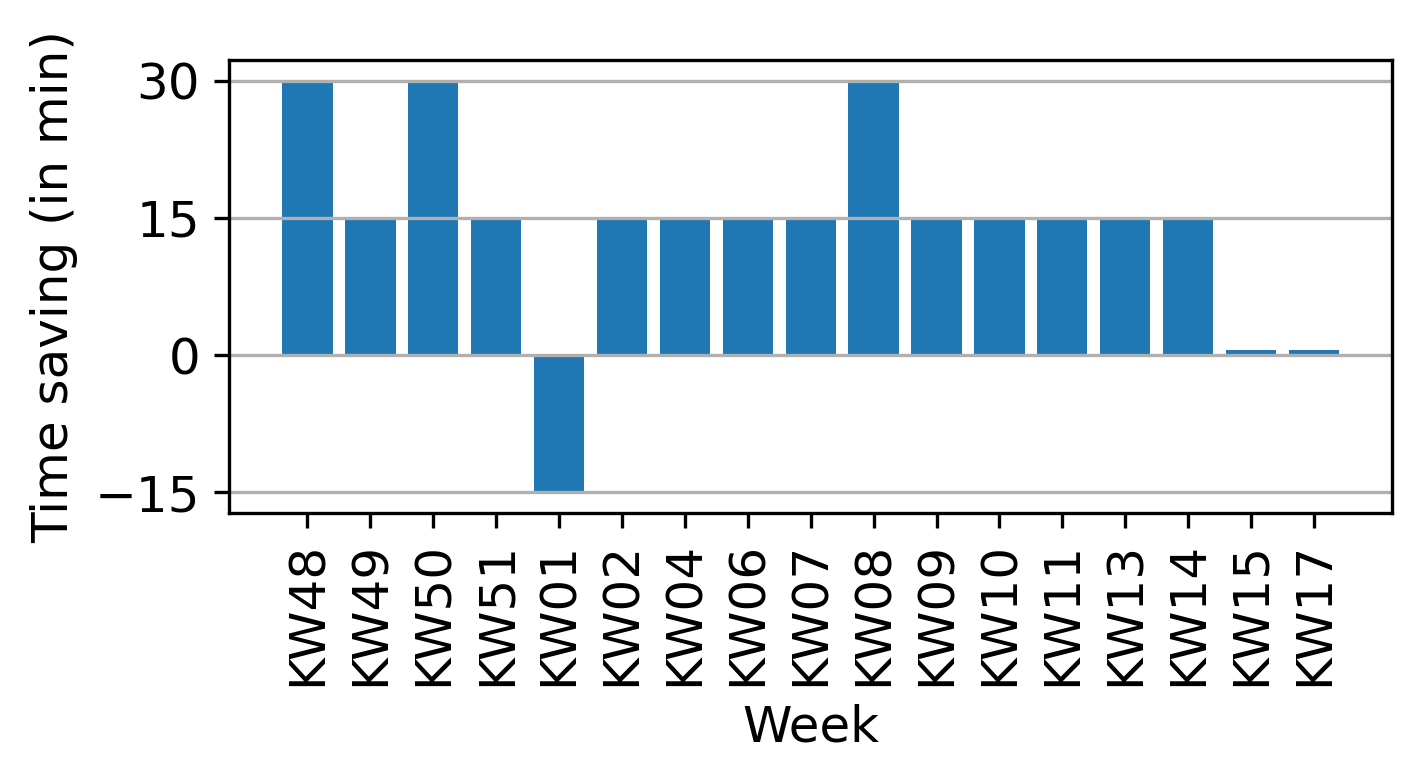

In [7]:
df_savings = pd.DataFrame([], columns=['saving'])

for week, row in df_results.iterrows():
    saving = row['IST-OCT'] - row['OPT-OCT']
    if saving == 0:
        saving = 0.5
    df_savings.loc[week] = [saving]

plt.figure(figsize=(5, 2))
plt.grid(axis='y')
plt.xlabel('Week', fontsize=12)
plt.ylabel('Time saving (in min)', fontsize=12)
plt.xticks(rotation=90, fontsize=12)
plt.yticks(range(-15, 31, 15), fontsize=12)
plt.bar(df_savings.index, df_savings['saving'])
# tikzplotlib.save('evaluation_savings.tex')
plt.show()

## Comparison of the actual and computed plans for a certain week

In [8]:
week = 'KW01'

actual_order = df_results.at[week, 'actual_order']
computed_order = df_results.at[week, 'computed_order']

print('actual_order:', actual_order)
print('computed_order:', computed_order)

actual_order: ['23545', '18920', '22721', '16215', '15951', '12021', '12020', '22720', '18919', '15101', '15227', '15229', '15099', '15952', '13327', '21865', '21847', '21846', '21849', '23614', '23149', '23151', '23547']
computed_order: ['23545', '22721', '18920', '15951', '16215', '12021', '12020', '15227', '18919', '22720', '15101', '21849', '23614', '21847', '21846', '21865', '15099', '15229', '15952', '13327', '23149', '23151', '23547']


In [9]:
actual_plan = []
for product in actual_order:
    properties = df_properties.loc[product].to_list()
    df_actual_plan = actual_plans[week]
    quantity = int(df_actual_plan[df_actual_plan['Produkt'] == product]['Menge'].iloc[0]) * 1000
    actual_plan.append([product] + properties + [quantity])

df_actual = pd.DataFrame(actual_plan, columns=['Product'] + df_properties.columns.to_list() + ['Quantity']).set_index('Product')
df_actual

,Name,Campaign,Volume,BottleCrate,NumShrink,NumTray,Packaging,PlannedPerformance,Quantity
Product,,,,,,,,,
23545,Sterilisation zu Wochenbeginn,Sterilisation_zu_Wochenbeginn,0,-,0,0,-,1,0
18920,Riv. Blau Sc 6x150 PE Halbpalett,Blau,150,False,1,6,Halbpaletten,13500,35000
22721,Rivella Blau Sc 6x150 PE HPB,Blau,150,False,1,6,HPB,13500,55000
16215,Rivella Blau Tr 4x6x50 PE HPB,Blau,50,False,4,6,HPB,18000,50000
15951,Rivella Blau Tr 4x6x50 PE,Blau,50,False,4,6,Normal,18000,150000
12021,Rivella Blau Tr 24x50 PE,Blau,50,False,1,24,Normal,19500,70000
12020,Rivella Rot Tr 24x50 PE,Rot,50,False,1,24,Normal,19500,100000
22720,Rivella Rot Sc 6x150 PE HPB,Rot,150,False,1,6,HPB,13500,20000
18919,Rivella Rot Sc 6x150 PE Halbpaletten,Rot,150,False,1,6,Halbpaletten,13500,55000


In [10]:
computed_plan = []
for product in computed_order:
    properties = df_properties.loc[product].to_list()
    df_actual_plan = actual_plans[week]
    quantity = int(df_actual_plan[df_actual_plan['Produkt'] == product]['Menge'].iloc[0]) * 1000
    computed_plan.append([product] + properties + [quantity])

df_computed = pd.DataFrame(computed_plan, columns=['Product'] + df_properties.columns.to_list() + ['Quantity']).set_index('Product')
df_computed

,Name,Campaign,Volume,BottleCrate,NumShrink,NumTray,Packaging,PlannedPerformance,Quantity
Product,,,,,,,,,
23545,Sterilisation zu Wochenbeginn,Sterilisation_zu_Wochenbeginn,0,-,0,0,-,1,0
22721,Rivella Blau Sc 6x150 PE HPB,Blau,150,False,1,6,HPB,13500,55000
18920,Riv. Blau Sc 6x150 PE Halbpalett,Blau,150,False,1,6,Halbpaletten,13500,35000
15951,Rivella Blau Tr 4x6x50 PE,Blau,50,False,4,6,Normal,18000,150000
16215,Rivella Blau Tr 4x6x50 PE HPB,Blau,50,False,4,6,HPB,18000,50000
12021,Rivella Blau Tr 24x50 PE,Blau,50,False,1,24,Normal,19500,70000
12020,Rivella Rot Tr 24x50 PE,Rot,50,False,1,24,Normal,19500,100000
15227,Rivella Rot Sc 6x100 PE,Rot,100,False,1,6,Normal,13000,15000
18919,Rivella Rot Sc 6x150 PE Halbpaletten,Rot,150,False,1,6,Halbpaletten,13500,55000


In [11]:
df_actual.to_csv(f'actual_{week}.csv')
df_computed.to_csv(f'computed_{week}.csv')

### Export evaluation to excel

In [51]:
from openpyxl.styles import PatternFill

colors = {
    'Header': 'A6A6A6',
    'Sterilisation_zu_Wochenbeginn': 'D9D9D9',
    'Rot': 'DA9694',
    'Blau': '8DB4E2',
    'Gruentee': 'C4D79B',
    'Refresh': 'FABF8F',
    'Minze': 'B1A0C7',
    'Grapefruit': '948A54',
    'Wochenendreinigung': 'D9D9D9',
    'Zwischensterilisation': 'D9D9D9',
    'default': 'FFFFFF'
}

def format_sheet(sheet, df):
    sheet.column_dimensions['A'].width = 10
    sheet.column_dimensions['B'].width = 35
    sheet.column_dimensions['C'].width = 29
    sheet.column_dimensions['D'].width = 8
    sheet.column_dimensions['E'].width = 11
    sheet.column_dimensions['F'].width = 11
    sheet.column_dimensions['G'].width = 9
    sheet.column_dimensions['H'].width = 12
    sheet.column_dimensions['I'].width = 20
    sheet.column_dimensions['J'].width = 9
    
    for row in sheet[f'A1:J{len(df) + 1}']:
        color = colors['default']
        if row[0].row == 1:
            color = colors['Header']
        else:
            campaign = df['Campaign'].iloc[row[0].row - 2]
            if campaign in colors:
                color = colors[campaign]
        for cell in row:
            cell.fill = PatternFill("solid", start_color=color)

with pd.ExcelWriter(f'evaluation_{week}.xlsx', engine='openpyxl') as writer:
    sheet_name = f'actual_{week}'
    df_actual.to_excel(writer, sheet_name)

    sheet = writer.sheets[sheet_name]
    format_sheet(sheet, df_actual)

    
    sheet_name = f'computed_{week}'
    df_computed.to_excel(writer, sheet_name)

    sheet = writer.sheets[sheet_name]
    format_sheet(sheet, df_computed)

    
    sheet_name = f'comparsion_{week}'
    df_comparison = pd.concat([df_actual['Name'].reset_index(),
        pd.DataFrame([''] * len(df_actual), columns=['']),
        df_computed['Name'].reset_index()], axis=1)
    df_comparison.to_excel(writer, sheet_name, index=False)

    sheet = writer.sheets[sheet_name]

    sheet.column_dimensions['A'].width = 10
    sheet.column_dimensions['B'].width = 35
    sheet.column_dimensions['C'].width = 20
    sheet.column_dimensions['D'].width = 10
    sheet.column_dimensions['E'].width = 35

    for row in sheet[f'A1:B{len(df_actual) + 1}']:
        color = colors['default']
        if row[0].row == 1:
            color = colors['Header']
        else:
            campaign = df_actual['Campaign'].iloc[row[0].row - 2]
            if campaign in colors:
                color = colors[campaign]
        for cell in row:
            cell.fill = PatternFill("solid", start_color=color)

    for row in sheet[f'D1:E{len(df_computed) + 1}']:
        color = colors['default']
        if row[0].row == 1:
            color = colors['Header']
        else:
            campaign = df_computed['Campaign'].iloc[row[0].row - 2]
            if campaign in colors:
                color = colors[campaign]
        for cell in row:
            cell.fill = PatternFill("solid", start_color=color)